In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from geopy.geocoders import Nominatim
import re

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
darkmode = True
if darkmode:
    jtplot.style(theme='grade3', context='notebook', ticks=True, grid=True)

## extract data

In [2]:
df_2020 = pd.read_csv(r'data/raw/huie_surveyData_2020.csv')
df_2021 = pd.read_csv(r'data/raw/huie_surveyData_2021.csv')

print(f'The 2020 survey has {len(df_2020)} partcipants.')
print(f'The 2021 survey has {len(df_2021)} partcipants.')

The 2020 survey has 362 partcipants.
The 2021 survey has 961 partcipants.


## transform & clean data

In [86]:
REGIONS = np.array(
            ["Northland/Te Tai Tokerau",
            "Auckland/Tāmakimakaurau", 
            "Waikato",
            "Bay of Plenty/Te MoanaaToi",
            "Gisborne/Te Tai Rāwhiti",
            "Hawke's Bay/Te Mataua Māui",
            "Taranaki",
            "Manawatū-Whanganui",
            "Wellington/Te WhanganuiaTara",
            "Tasman/Te TaioAorere",
            "Nelson/Whakatū",
            "Marlborough/Te Tauihuotewaka",
            "West Coast /Te Tai Poutini",
            "Canterbury/Waitaha",
            "Otago/Ōtākou",
            "Southland/Murihiku",
            "All regions of the North Island/Te IkaaMāui",
            "All regions of the South Island/Te Wai Pounamu",
            "All regions of Aotearoa/New Zealand"]
)

# define function to aggregate data based on the columns
def aggregate_regions(df_in, reg_cols, col_name='location'):
    '''
    Takes raw df as input and outputs df with aggregated 
    regions for each entry in new location column
    '''
    df_out = df_in.copy()
    
    df_out = df_out.replace(np.nan, '', regex=True)                        # replace nans for easier agreggation
    df_out[col_name] = df_out[reg_cols].T.agg(','.join)             # aggregation
    df_out = df_out.replace(',,', '', regex=True)                        # gets rid of double commas
    
    return df_out

 
def remove_comma(df_in, which):
    '''
    Inputs df from aggregate_regions output and removes the 
    '''
    df_out = df_in.copy()

    # track what comma to remove (index) based on which input
    ind = 0 if which == 'first'  else -1
    # remove comma with lambda function
    with_comma = [(lambda s: s[ind] == ',')(s) for s in df_in['location']]
    if which == 'first': 
        df_out['location'][with_comma] = df_out['location'][with_comma].map(lambda s: str(s)[1:])
    elif which == 'last':
        df_out['location'][with_comma] = df_out['location'][with_comma].map(lambda s: str(s)[:-1])
        
    return df_out



# define function to ensure that there's no entry with an empty location
def gis_quality_check(df_in):
    '''
    Checks for empty entries in the location column for input df_in
    '''
    
    print(f'='*60)
    print(f'Carrying out data quality check:')
    print(f'-'*35)
    
    is_loc_empty =  [(lambda s: s == '')(s) for s in df_in['location']]
    n_empty = len(df_in['location'][is_loc_empty])
                
    if n_empty == 0:
        print(f'The data has no empty entries in the location column')
        print(f'='*60)
    else:
        print(f'The data has {n_empty} empty entries in the location column')
        print(f'='*60)

# call region aggregator
region_cols = ['In which region(s) does your organisation operate (please choose all that apply)'] + [f'Unnamed: {j}' for j in range(14,32+1)]
df_2020 = aggregate_regions(df_2020, region_cols)

# call function to remove comma 
df_2020 = remove_comma(df_2020, which='first')
df_2020 = remove_comma(df_2020, which='last')

# call quality data function to check for empty entries
gis_quality_check(df_2020)
    
print(df_2020.loc[5, 'location'])
print(df_2020.loc[2, 'location'])

#[is_comma_first(val) for val in df_2020['location'].values]

Carrying out data quality check:
-----------------------------------
The data has no empty entries in the location column
Auckland/Tāmaki-makau-rau,Waikato,Manawatū-Whanganui,Wellington/Te Whanga-nui-a-TaraNelson/Whakatū,Canterbury/Waitaha,Otago/Ōtākou
Southland/Murihiku


## group data for counting regions

In [154]:
# because the shape of the data, it's better to do this manually than using df.groupby()
#df_2020_grouped = df_2020.groupby('location')['Respondent ID'].size()
groups = df_2020['location'].values

generic_regions = [
    "All regions of the North Island/Te IkaaMāui",
    "All regions of the South Island/Te Wai Pounamu",
    "All regions of Aotearoa/New Zealand"
]

count_reg_dict = {reg.split('/')[0]:0 for reg in REGIONS if reg not in generic_regions}

redundant_regions = [
    "All regions of the South Island",
    "All regions of the North Island",
    "TaranakiWellington",
    "We don't operate in Aotearoa",
    "WaikatoAll regions of Aotearoa"
]

for i, group in enumerate(groups):
    regions = group.split(',')
    for j, item in enumerate(regions):
        region = item.split('/')[0]
        if region == "All regions of Aotearoa":
            pass
            #count_reg_dict.update({f'{key}': val+1 for (key,val) in count_reg_dict.items()})
        elif region in redundant_regions:
            pass
        else:
            count_reg_dict[region] += 1

def remove_emptychar(df_in, col_name='region'):
    df_out = df_in.copy()
    
    with_endspace = [(lambda s: s[-1] == ' ')(s) for s in df_in[col_name].values]
    df_out[col_name][with_endspace] = df_out[col_name][with_endspace].map(lambda s: str(s)[:-1])
    
    return df_out

# turn dictionary into 
df_regcount = pd.DataFrame(count_reg_dict.items(), columns=['region', 'participation_count'])
df_regcount = remove_emptychar(df_regcount, col_name='region')
# add partcipation percentage
df_regcount['participation_perc'] = np.round((df_regcount.participation_count/df_regcount.participation_count.sum())*100, 1)

df_regcount

/var/folders/kb/bby1vm3n6y32dqqtvh28znc40000gn/T/ipykernel_82318/2236286308.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out[col_name][with_endspace] = df_out[col_name][with_endspace].map(lambda s: str(s)[:-1])


,region,participation_count,participation_perc
0,Northland,33,6.0
1,Auckland,83,15.1
2,Waikato,65,11.8
3,Bay of Plenty,41,7.4
4,Gisborne,22,4.0
5,Hawke's Bay,24,4.4
6,Taranaki,21,3.8
7,Manawatū-Whanganui,32,5.8
8,Wellington,62,11.3
9,Tasman,13,2.4


## pull gdp per capita data

In [206]:
#reg_fn = [(lambda s: str(s).lower())(s) for s in count_reg_dict]

def extract_gdp(fp="data/processed/gdp-per-capita_2020_regional.csv"):
    '''
    Extracts the gdp per capita for each region (separate csv file)
    and pulls it into a master df. All dataset are publicly available here:
    http://webrear.mbie.govt.nz/theme/gdp-per-capita/map/timeseries/2020/new-zealand?right-transform=absolute
    '''

    df_list = []
    for i, region in enumerate(df_regcount['region']):

        # define filename
        reg_fn = region.lower()
        # need to add all this logic so files are read properly
        if reg_fn == r"bay of plenty":
            reg_fn = r"bay-of-plenty"
        elif reg_fn == r"hawke's bay":
            reg_fn = r"hawkes-bay"
        elif reg_fn == r"manawatū-whanganui":
            reg_fn = "manawatu-wanganui"
        elif reg_fn == r"west coast":
            reg_fn = "west-coast"
        # extract data
        filename = f"gdp-per-capita-annual-mar-{reg_fn}--annual-rate.csv"
        df_i = pd.read_csv(f"data/gis/gdp/"+filename)
        
        # transform df  
        df_i = df_i[df_i['Year'] == 2020]                                                       # only take the GDP for the most recent year available (2020)
        df_i['region'] = region                                                                 # add column with region
        df_i = df_i[['region', 'The GDP per capita']]                                           # get rid of redundant columns
        df_i = df_i.rename(columns={'The GDP per capita': 'gdp_pc'})                            # rename column for easier processing (GDP is in NZD)
        df_i['gdp_pc'] = df_i['gdp_pc'].replace(',', '', regex=True).astype(np.int32)           # transform gdp from str to int (need to get rid of commas first) 
    
                         
        df_list.append(df_i)
    
    # concatenate dataframe and save it
    df_gdp = pd.concat(df_list, ignore_index=True)
    df_gdp.to_csv(fp, index=False)

    
# extract gdp per capita and load into dataframe
filepath_gdp = "data/processed/gdp-per-capita_2020_regional.csv"
try:
    df_gdp = pd.read_csv(filepath_gdp)
except FileNotFoundError:
    extract_gdp(fp=filepath_gdp)
    
# create column of gdp_pc percentage
df_gdp['gdp_pc_perc'] = np.round((df_gdp.gdp_pc/df_gdp.gdp_pc.sum())*100, 1)

df_gdp

,region,gdp_pc,gdp_pc_perc
0,Northland,42251,4.5
1,Auckland,71358,7.6
2,Waikato,56139,6.0
3,Bay of Plenty,55986,6.0
4,Gisborne,45345,4.8
5,Hawke's Bay,50913,5.4
6,Taranaki,76348,8.1
7,Manawatū-Whanganui,48864,5.2
8,Wellington,74303,7.9
9,Tasman,46905,5.0


## gis analysis (with NZ map)

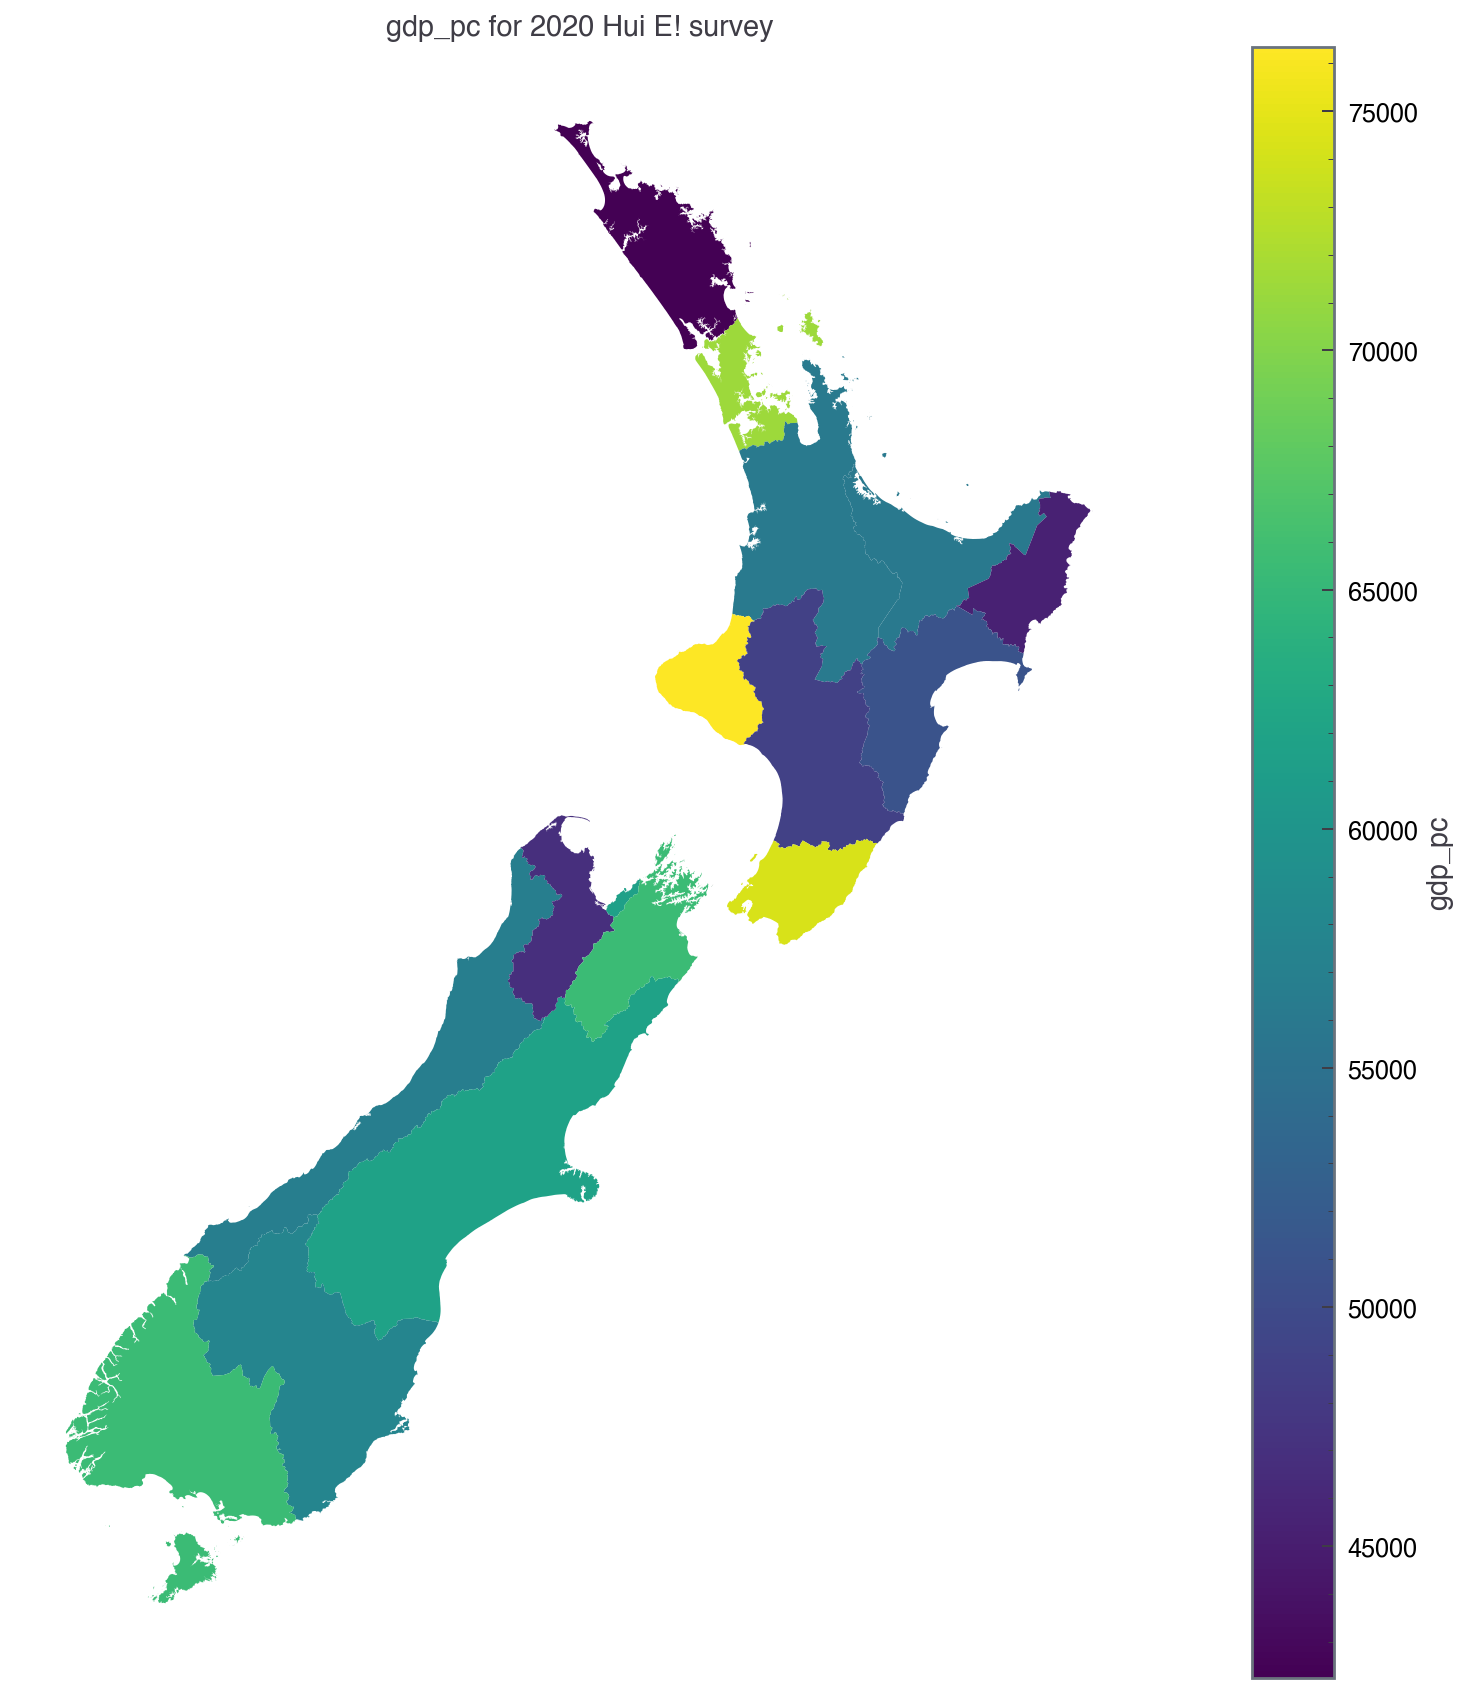

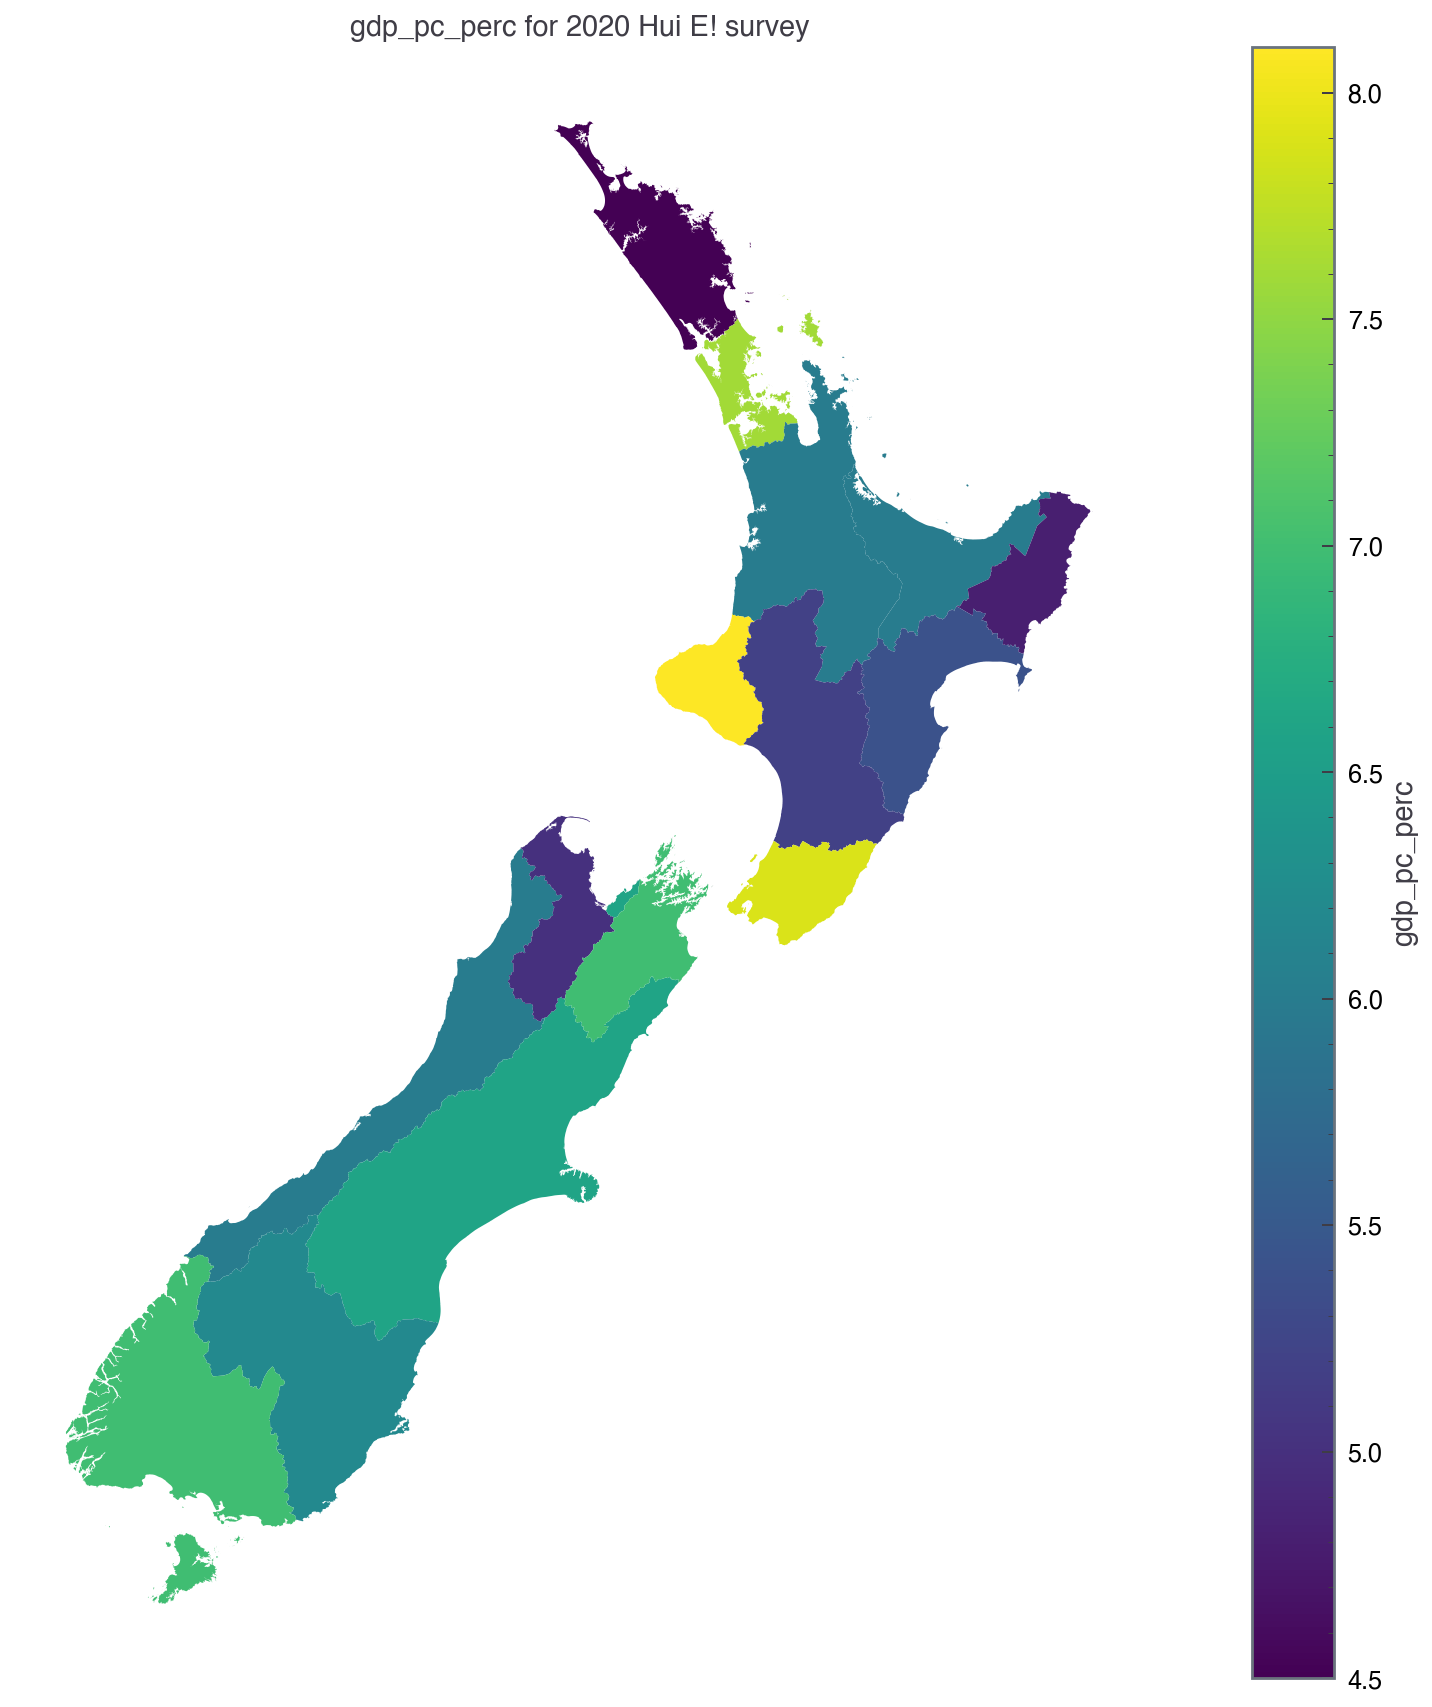

In [213]:
import geopandas as gpd

def extract_geodataframe(csv_fp, shp_fp):
    '''
    Reads the csv and shp files from NZ's regional councils and
    creates a geodataframe to plot the map of NZ. Files publicily available here:
    https://datafinder.stats.govt.nz/layer/106667-regional-council-2022-clipped-generalised/
    '''
    gdf_shp = gpd.read_file(csv_fp)
    gdf_csv = gpd.read_file(shp_fp)

    # get rid of redundand columns and of extra region wording
    gdf_csv = gdf_csv[["REGC2022_V1_00_NAME"]]
    gdf_csv = gdf_csv.replace(' Region', '', regex=True)  
    gdf_csv = gdf_csv.rename(columns={'REGC2022_V1_00_NAME': 'region'})
    # join two dataframes and get rid of Outside NZ region
    gdf_map = gdf_csv.merge(gdf_shp, left_index=True, right_index=True)
    gdf_map = gdf_map.drop(gdf_map.index[-1], axis=0)
    gdf_map = gpd.GeoDataFrame(gdf_map)
    
    return gdf_map

#def data2gdf(gdf):

# define function to draw NZ map
def draw_map(gdf, col_count=None):
    '''
    Draws map of input dataframe (assume multipolygon) geometry
    '''
    
    fig, ax = plt.subplots(figsize=(24,15))
    
    if col_count is None:
        gdf.plot(ax=ax)
    else:
        gdf.plot(
            ax=ax, 
            column=col_count, 
            legend=True,
            legend_kwds={'label': col_count}
                )
        plt.title(f"{col_count} for 2020 Hui E! survey")
        plt.subplots_adjust(right=0.75)
    
    plt.axis("off")
    plt.show()
    
    

# call function to extract geodataframe of NZ's regional councils
csv_filepath = "data/gis/regional-council-2022-clipped-generalised.shx"
shp_filepath = "data/gis/regional_council_2022_clipped_csv.csv"
gdf_map = extract_geodataframe(csv_filepath, shp_filepath)

# merge geodataframe and counting df
df_metrics = df_regcount.merge(df_gdp, left_on='region', right_on='region') 

gdf_new = gdf_map.merge(df_metrics, left_on='region', right_on='region') 
gdf_new = gpd.GeoDataFrame(gdf_new)

#df_metrics

# call map drawing function
#draw_map(gdf_new, col_count='participation_perc')
#draw_map(gdf_new, col_count='participation_count')
draw_map(gdf_new, col_count='gdp_pc')
draw_map(gdf_new, col_count='gdp_pc_perc')

## questions for quotes 

In [6]:
text = 'The COVID-19 pandemic has had multiple structural/operational/financial impacts upon our tangata whenua, community and voluntary organisations in Aotearoa/New Zealand. That considered, the pandemic may have also had impacts on the wellbeing and emotional/morale status and stress levels of people in these organisations. Can you tell us a short story about your experiences?'

if False:
    print(df_2021[text].values)